In [3]:
# Block 1: 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 机器学习库
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from xgboost import XGBClassifier

# 设置绘图风格与字体（解决中文乱码）
sns.set(style="whitegrid", palette="muted")
plt.rcParams['font.sans-serif'] = ['SimHei'] # Windows系统使用 SimHei
# plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] # 如果是Mac系统，请取消这行的注释，注释上一行
plt.rcParams['axes.unicode_minus'] = False 

print("环境配置完成！")

环境配置完成！


In [4]:
# Block 2: 数据加载与预处理
import os

file_path = r"./data/WA_Fn-UseC_-HR-Employee-Attrition.csv" 

try:
    df = pd.read_csv(file_path)
    print(f"数据加载成功！")
    print(f"数据位置: {file_path}")
    print(f"数据形状: {df.shape}")
except FileNotFoundError:
    print(f"错误：找不到文件！请检查路径是否正确：\n{file_path}")
    # 停止运行后续代码，避免更多报错
    raise

# 下面是通用的清洗步骤（不用改）
# 1. 删除无用特征
df.drop(['EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber'], axis=1, inplace=True)

# 2. 标签编码
df['Attrition'] = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3. 特征编码
df = pd.get_dummies(df, drop_first=True)

print("数据预处理完成！")
df.head()

数据加载成功！
数据位置: ./data/WA_Fn-UseC_-HR-Employee-Attrition.csv
数据形状: (1470, 35)
数据预处理完成！


,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,41,1,1102,1,2,2,94,3,2,4,...,False,False,False,False,False,True,False,False,True,True
1,49,0,279,8,1,3,61,2,2,2,...,False,False,False,False,True,False,False,True,False,False
2,37,1,1373,2,2,4,92,2,1,3,...,True,False,False,False,False,False,False,False,True,True
3,33,0,1392,3,4,4,56,3,1,3,...,False,False,False,False,True,False,False,True,False,True
4,27,0,591,2,1,1,40,3,1,2,...,True,False,False,False,False,False,False,True,False,False


In [5]:
# Block 3: 划分训练集与测试集
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# stratify=y 确保训练集和测试集中离职人员的比例一致
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 计算 scale_pos_weight (负样本/正样本)
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

print(f"训练集大小: {X_train.shape}")
print(f"测试集大小: {X_test.shape}")
print(f"类别权重比 (scale_pos_weight): {ratio:.2f}")

训练集大小: (1176, 44)
测试集大小: (294, 44)
类别权重比 (scale_pos_weight): 5.19


In [6]:
# Block 4: 定义模型与参数网格 (修正版)

# 初始化 XGBoost
xgb = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=ratio,
    # use_label_encoder=False,  <-- 这一行删掉，或者注释掉
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# 定义要搜索的参数范围
param_grid = {
    'n_estimators': [50, 100, 200],      # 树的数量
    'max_depth': [3, 5, 7],              # 树的深度
    'learning_rate': [0.01, 0.1, 0.2],   # 学习率
    'subsample': [0.8, 1.0]              # 采样比例
}

# 设置网格搜索
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1', # 以 F1 分数为优化目标
    cv=5,         # 5折交叉验证
    verbose=1,
    n_jobs=-1
)

print("模型配置完成，准备训练...")

模型配置完成，准备训练...


In [7]:
# Block 5: 执行网格搜索 (Training)
print("开始训练模型，请稍候...")

grid_search.fit(X_train, y_train)

print("\n训练结束！")
print(f"最优参数: {grid_search.best_params_}")
print(f"最佳验证集得分 (F1): {grid_search.best_score_:.4f}")

# 提取最佳模型
best_model = grid_search.best_estimator_

开始训练模型，请稍候...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

训练结束！
最优参数: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
最佳验证集得分 (F1): 0.5294


In [8]:
# Block 6: 输出评估指标
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("--- 最终模型评估报告 ---")
print(f"Accuracy (准确率): {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC Score (AUC值): {roc_auc_score(y_test, y_pred_proba):.4f}")
print("\n详细分类报告:\n")
print(classification_report(y_test, y_pred))

--- 最终模型评估报告 ---
Accuracy (准确率): 0.8129
AUC Score (AUC值): 0.7668

详细分类报告:

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       247
           1       0.42      0.43      0.42        47

    accuracy                           0.81       294
   macro avg       0.65      0.66      0.65       294
weighted avg       0.81      0.81      0.81       294



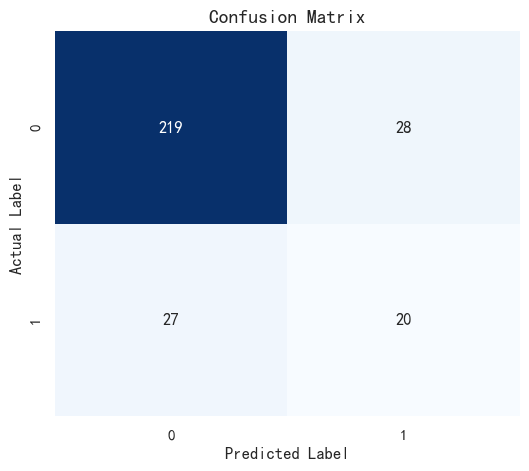

C:\Users\31917\AppData\Local\Temp\ipykernel_110984\653457297.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')


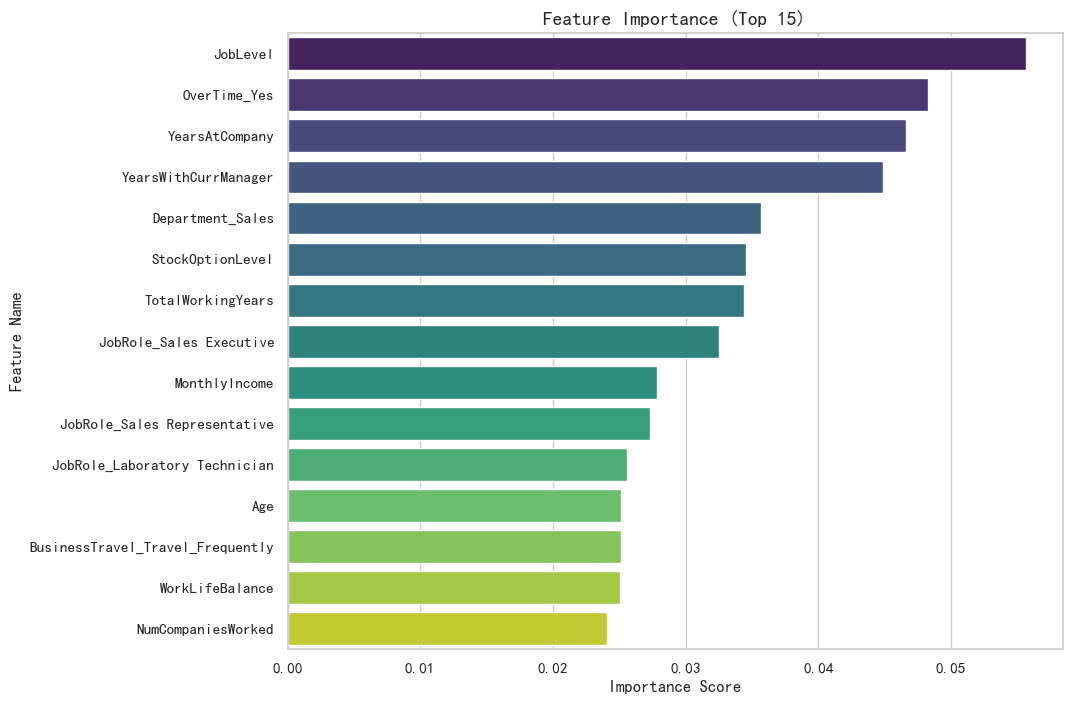

C:\Users\31917\AppData\Local\Temp\ipykernel_110984\653457297.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='navy')


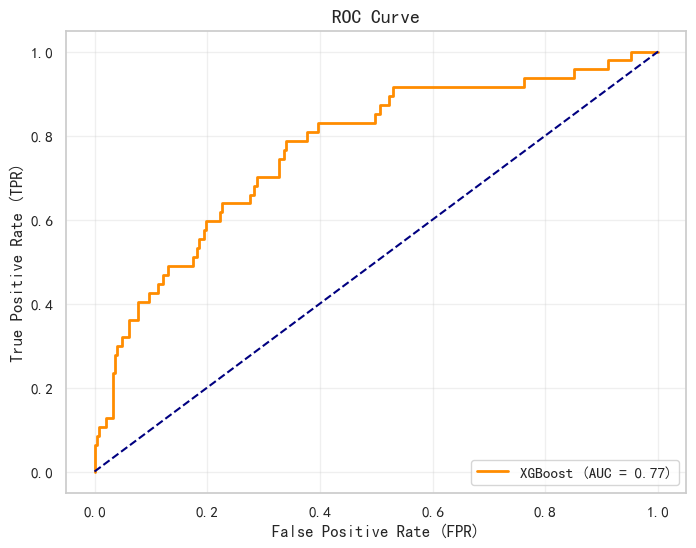

In [ ]:
# Block 7: 绘制可视化图表

# 1. 混淆矩阵 (Confusion Matrix)
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 2. 特征重要性 (Feature Importance)
importances = best_model.feature_importances_
feature_names = X.columns
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
plt.title('Feature Importance (Top 15)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.show()

# 3. ROC 曲线 (ROC Curve)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})', linewidth=2, color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', color='navy')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()